# Run the simulation notebook for one set of parameters


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from gammapy.datasets import Datasets
from gammapy.estimators import ExcessMapEstimator
from simulation_extended import *
from regions import CircleSkyRegion
from gammapy.makers import FoVBackgroundMaker

In [2]:
simulator = Simulation()
estimator = ExcessMapEstimator(correlation_radius=0.1*u.deg,
                             selection_optional=None)

The number of simulated obs is 4*n_obs, ie, n_obs is the number of runs simulated at each wobble position. For now, it is the same.
Can make it a list if really necessary

In [3]:
%%time
sigma = 0.3*u.deg
A0 = 5e-11
n_obs = 5
datasets = simulator.run(n_obs=n_obs, sigma=sigma, A0=A0)

Pointing position: 
 <SkyCoord (Galactic): (l, b) in deg
    (0.7, 0.)>
Pointing position: 
 <SkyCoord (Galactic): (l, b) in deg
    (359.3, 0.)>
Pointing position: 
 <SkyCoord (Galactic): (l, b) in deg
    (0., 0.7)>
Pointing position: 
 <SkyCoord (Galactic): (l, b) in deg
    (0., -0.7)>
CPU times: user 24.4 s, sys: 4.07 s, total: 28.4 s
Wall time: 28.5 s


(array([5., 1., 2., 1., 3., 1., 4., 1., 1., 1.]),
 array([0.84109357, 0.89514938, 0.94920518, 1.00326098, 1.05731679,
        1.11137259, 1.16542839, 1.2194842 , 1.27354   , 1.3275958 ,
        1.38165161]),
 <BarContainer object of 10 artists>)

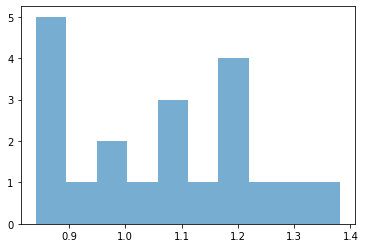

In [4]:
# The injected background systematics are stored in bkg_norms
plt.hist(simulator.bkg_norms, alpha=0.6)

In [5]:
# Stack the datasets for visualisation
stacked = datasets.stack_reduce()

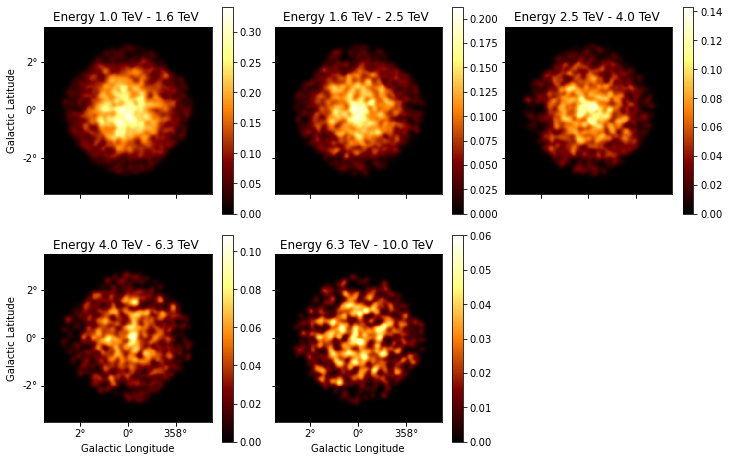

In [6]:
stacked.counts.smooth(0.1*u.deg).plot_grid(add_cbar=True);

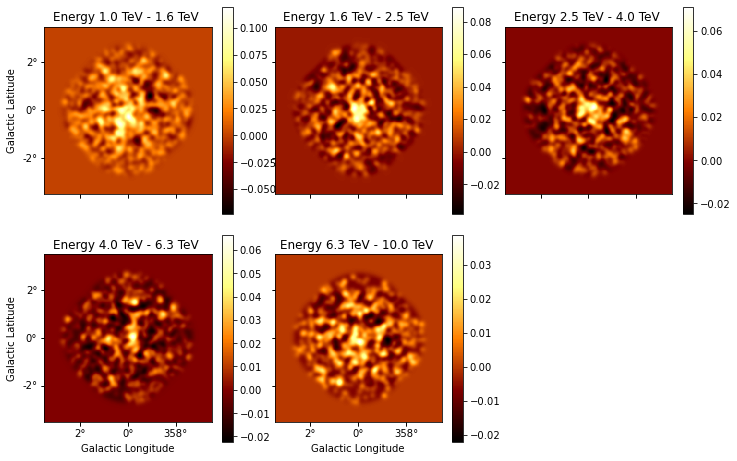

In [7]:
(stacked.counts - stacked.background).smooth(0.1*u.deg).plot_grid(add_cbar=True);

/opt/anaconda3/envs/gammapy-dev/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


(<Figure size 432x288 with 2 Axes>,
 <WCSAxesSubplot:xlabel='Galactic Longitude', ylabel='Galactic Latitude'>,
 <matplotlib.colorbar.Colorbar at 0x16f6fce48>)

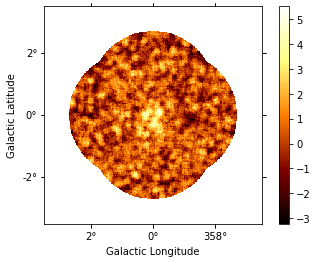

In [8]:
residual1 = estimator.run(stacked)
residual1['sqrt_ts'].plot(add_cbar=True)

In [9]:
#The injected model parameters
model = simulator.sky_model(sigma.value, A0)
model.parameters.to_table()

name,value,unit,min,max,frozen,error
str9,float64,str8,float64,float64,bool,int64
amplitude,4.5000e-12,cm-2 s-1,nan,nan,False,0.000e+00
index,2.3000e+00,,nan,nan,False,0.000e+00
emin,1.0000e+00,TeV,nan,nan,True,0.000e+00
emax,1.0000e+01,TeV,nan,nan,True,0.000e+00
lon_0,0.0000e+00,deg,nan,nan,False,0.000e+00
lat_0,0.0000e+00,deg,-9.000e+01,9.000e+01,False,0.000e+00
sigma,3.0000e-01,deg,0.000e+00,nan,False,0.000e+00
e,0.0000e+00,,0.000e+00,1.000e+00,True,0.000e+00
phi,0.0000e+00,deg,nan,nan,True,0.000e+00


In [10]:
minor_axis = model.spatial_model.sigma.quantity * np.sqrt(1 - model.spatial_model.e.value ** 2)

surface_brightness = model.spectral_model.amplitude.quantity/(4*np.pi*minor_axis*model.spatial_model.sigma.quantity)
print(surface_brightness.to(1/(u.cm**2 * u.s * u.sr)))

1.3061871445445791e-08 1 / (cm2 s sr)


1710.0 1340.7156808389589 0.27543820396727203


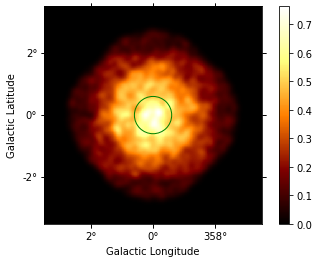

In [11]:
#Source strength as a fraction of background
region = CircleSkyRegion(center=simulator.skydir,
                        radius=2.0*sigma)
bkg_strength = stacked.background.get_spectrum(region).data.sum()
src_strength = stacked.counts.get_spectrum(region).data.sum()

fig, ax, _ = stacked.counts.sum_over_axes().smooth(0.1*u.deg).plot(add_cbar=True)
region.to_pixel(wcs=stacked._geom.wcs).plot(edgecolor='green');

print(src_strength, bkg_strength, (src_strength - bkg_strength)/bkg_strength)

## Extract with the ring background

In [12]:
from ring_background import *

In [13]:
mask = make_mask(datasets, 
                 source_pos=simulator.skydir, 
                 source_radius=2.0*sigma)

In [14]:
%%time
stacked_on_off = extract_ring(datasets=datasets,
                              exclusion_mask=mask
                             )

/opt/anaconda3/envs/gammapy-dev/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/opt/anaconda3/envs/gammapy-dev/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/opt/anaconda3/envs/gammapy-dev/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/opt/anaconda3/envs/gammapy-dev/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/opt/anaconda3/envs/gammapy-dev/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value

CPU times: user 2.8 s, sys: 428 ms, total: 3.23 s
Wall time: 2.55 s


/opt/anaconda3/envs/gammapy-dev/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/opt/anaconda3/envs/gammapy-dev/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


/opt/anaconda3/envs/gammapy-dev/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/asinha/Gammapy-dev/gammapy/gammapy/stats/counts_statistic.py:233: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.n_on + self.alpha ** 2 * self.n_off)
/opt/anaconda3/envs/gammapy-dev/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


(<Figure size 432x288 with 2 Axes>,
 <WCSAxesSubplot:xlabel='Galactic Longitude', ylabel='Galactic Latitude'>,
 <matplotlib.colorbar.Colorbar at 0x161ac2c50>)

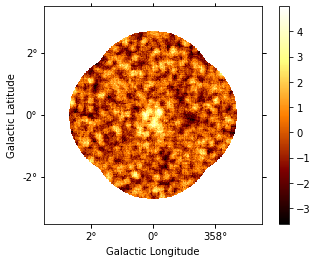

In [15]:
residual2 = estimator.run(stacked_on_off)
residual2['sqrt_ts'].plot(add_cbar=True)

Fit results: mu = -0.04, std = 0.99


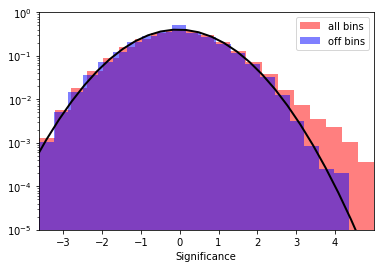

In [16]:
significance_map_off = residual2['sqrt_ts'] * mask
significance_all = residual2['sqrt_ts'].data[np.isfinite(residual2['sqrt_ts'].data)]
significance_off = significance_map_off.data[
    np.isfinite(significance_map_off.data)
]

plt.hist(
    significance_all,
    density=True,
    alpha=0.5,
    color="red",
    label="all bins",
    bins=21,
)

plt.hist(
    significance_off,
    density=True,
    alpha=0.5,
    color="blue",
    label="off bins",
    bins=21,
)

# Now, fit the off distribution with a Gaussian
mu, std = norm.fit(significance_off)
x = np.linspace(-8, 8, 50)
p = norm.pdf(x, mu, std)
plt.plot(x, p, lw=2, color="black")
plt.legend()
plt.xlabel("Significance")
plt.yscale("log")
plt.ylim(1e-5, 1)
xmin, xmax = np.min(significance_all), np.max(significance_all)
plt.xlim(xmin, xmax)

print(f"Fit results: mu = {mu:.2f}, std = {std:.2f}")

Now, fit using the ring background

In [17]:
#define the sky_model to fit to the data
sky_model = model.copy(name='ring_fit')
sky_model.spectral_model.parameters['index'].frozen = True

In [18]:
L0 = stacked_on_off.stat_sum()

/Users/asinha/Gammapy-dev/gammapy/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


In [19]:
# Add the sky model to the dataset
stacked_on_off.models = sky_model

In [20]:
# Now fit
fit = Fit([stacked_on_off])
result = fit.run()
print(result)

/Users/asinha/Gammapy-dev/gammapy/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/asinha/Gammapy-dev/gammapy/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/asinha/Gammapy-dev/gammapy/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/asinha/Gammapy-dev/gammapy/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/asinha/Gammapy-dev/gammapy/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/asinha/Gammapy-dev/gammapy/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divi

/Users/asinha/Gammapy-dev/gammapy/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/asinha/Gammapy-dev/gammapy/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/asinha/Gammapy-dev/gammapy/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/asinha/Gammapy-dev/gammapy/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/asinha/Gammapy-dev/gammapy/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/asinha/Gammapy-dev/gammapy/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divi

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 89
	total stat : 39404.03



/Users/asinha/Gammapy-dev/gammapy/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/asinha/Gammapy-dev/gammapy/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))
/Users/asinha/Gammapy-dev/gammapy/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


In [21]:
print(result.parameters.to_table())

   name      value      unit      min        max    frozen   error  
--------- ----------- -------- ---------- --------- ------ ---------
amplitude  4.6672e-12 cm-2 s-1        nan       nan  False 7.760e-13
    index  2.3000e+00                 nan       nan   True 0.000e+00
     emin  1.0000e+00      TeV        nan       nan   True 0.000e+00
     emax  1.0000e+01      TeV        nan       nan   True 0.000e+00
    lon_0 -2.3849e-03      deg        nan       nan  False 4.743e-02
    lat_0 -1.4853e-01      deg -9.000e+01 9.000e+01  False 6.072e-02
    sigma  2.8684e-01      deg  0.000e+00       nan  False 3.533e-02
        e  0.0000e+00           0.000e+00 1.000e+00   True 0.000e+00
      phi  0.0000e+00      deg        nan       nan   True 0.000e+00


In [22]:
L1 = stacked_on_off.stat_sum()
print('Detection del(TS) = ', L0-L1)

Detection del(TS) =  73.5978475088923


/Users/asinha/Gammapy-dev/gammapy/gammapy/stats/fit_statistics.py:197: RuntimeWarning: invalid value encountered in true_divide
  mu_bkg = (C + D) / (2 * alpha * (alpha + 1))


## Now, fit using 3D stacked analysis

- using background models

In [23]:
#This is the background maker
# We fit the background before stacking
maker_fov = FoVBackgroundMaker(method="scale", 
                               exclusion_mask=mask)

In [24]:
%%time
stacked3D = MapDataset.create(
    geom=datasets[0]._geom, 
    energy_axis_true=datasets[0].exposure.geom.axes['energy_true'], 
    name="stacked3D"
)
for dataset in datasets:
    dataset = maker_fov.run(dataset)
    stacked3D.stack(dataset)

CPU times: user 3.17 s, sys: 1 s, total: 4.17 s
Wall time: 4.17 s


In [25]:
print(stacked3D)

MapDataset
----------

  Name                            : stacked3D 

  Total counts                    : 14336 
  Total background counts         : 14079.63
  Total excess counts             : 256.37

  Predicted counts                : 14079.63
  Predicted background counts     : 14079.63
  Predicted excess counts         : nan

  Exposure min                    : 6.76e+08 m2 s
  Exposure max                    : 1.10e+10 m2 s

  Number of total bins            : 612500 
  Number of fit bins              : 267420 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : nan

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




In [26]:
model3D = model.copy(name='model3D')
bkg_model3D = FoVBackgroundModel(dataset_name="stacked3D")

In [27]:
stacked3D.models = bkg_model3D
L2 = stacked3D.stat_sum()

In [28]:
stacked3D.models = [bkg_model3D, model3D]

In [29]:
%%time
fit = Fit([stacked3D])
result = fit.run(optimize_opts={"print_level": 1})

------------------------------------------------------------------
| FCN = 1.02e+05                |     Ncalls=140 (140 total)     |
| EDM = 2.47e-05 (Goal: 0.0002) |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
CPU times: user 2.88 s, sys: 159 ms, total: 3.04 s
Wall time: 3.04 s


In [30]:
print(stacked3D.models.parameters.to_table())

   name      value      unit      min        max    frozen   error  
--------- ----------- -------- ---------- --------- ------ ---------
     norm  9.9426e-01                 nan       nan  False 9.356e-03
     tilt  0.0000e+00                 nan       nan   True 0.000e+00
reference  1.0000e+00      TeV        nan       nan   True 0.000e+00
amplitude  4.5493e-12 cm-2 s-1        nan       nan  False 8.979e-13
    index  2.0709e+00                 nan       nan  False 2.325e-01
     emin  1.0000e+00      TeV        nan       nan   True 0.000e+00
     emax  1.0000e+01      TeV        nan       nan   True 0.000e+00
    lon_0 -1.0092e-02      deg        nan       nan  False 4.812e-02
    lat_0 -1.0574e-01      deg -9.000e+01 9.000e+01  False 6.195e-02
    sigma  2.9392e-01      deg  0.000e+00       nan  False 3.955e-02
        e  0.0000e+00           0.000e+00 1.000e+00   True 0.000e+00
      phi  0.0000e+00      deg        nan       nan   True 0.000e+00


In [31]:
L3 = stacked3D.stat_sum()
print('Detection del(TS) = ', L2-L3)

Detection del(TS) =  74.39900467499683


## A joint 3D fitting

- This fits all the datasets together, 
- no stacking, it can be quite time consuming

In [32]:
maker_fov = FoVBackgroundMaker(method="fit", 
                               exclusion_mask=mask)
model3D_joint = model.copy(name='model3D_joint')
datasets_fit = Datasets()
for dataset in datasets:
    dataset = maker_fov.run(dataset)
    bkg_model = FoVBackgroundModel(dataset_name=dataset.name)
    dataset.models = [bkg_model, model3D_joint]
    datasets_fit.append(dataset)

In [33]:
datasets_fit.models.names

['dataset-0-0-bkg',
 'model3D_joint',
 'dataset-0-1-bkg',
 'dataset-0-2-bkg',
 'dataset-0-3-bkg',
 'dataset-0-4-bkg',
 'dataset-1-0-bkg',
 'dataset-1-1-bkg',
 'dataset-1-2-bkg',
 'dataset-1-3-bkg',
 'dataset-1-4-bkg',
 'dataset-2-0-bkg',
 'dataset-2-1-bkg',
 'dataset-2-2-bkg',
 'dataset-2-3-bkg',
 'dataset-2-4-bkg',
 'dataset-3-0-bkg',
 'dataset-3-1-bkg',
 'dataset-3-2-bkg',
 'dataset-3-3-bkg',
 'dataset-3-4-bkg']

In [34]:
%%time
fit_joint = Fit(datasets_fit)
result_joint = fit_joint.run()

CPU times: user 3min 10s, sys: 11.7 s, total: 3min 22s
Wall time: 3min 23s


In [35]:
model3D_joint.parameters.to_table()

name,value,unit,min,max,frozen,error
str9,float64,str8,float64,float64,bool,float64
amplitude,4.4410e-12,cm-2 s-1,nan,nan,False,8.669e-13
index,2.0801e+00,,nan,nan,False,2.330e-01
emin,1.0000e+00,TeV,nan,nan,True,0.000e+00
emax,1.0000e+01,TeV,nan,nan,True,0.000e+00
lon_0,-1.9399e-02,deg,nan,nan,False,4.747e-02
lat_0,-1.0852e-01,deg,-9.000e+01,9.000e+01,False,6.050e-02
sigma,2.8849e-01,deg,0.000e+00,nan,False,3.835e-02
e,0.0000e+00,,0.000e+00,1.000e+00,True,0.000e+00
phi,0.0000e+00,deg,nan,nan,True,0.000e+00


### Compare the injected background systematics vs the recompted ones

In [36]:
bkg_computed = []
bkg_err = []
for dataset in datasets_fit:
    bkg_computed.append(dataset.background_model.spectral_model.norm.value)
    bkg_err.append(dataset.background_model.spectral_model.norm.error)

Text(0, 0.5, 'reconstructed')

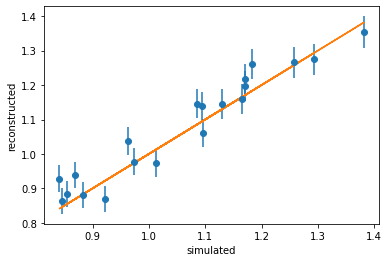

In [46]:
plt.errorbar(simulator.bkg_norms, bkg_computed, yerr=bkg_err, fmt='o')
plt.plot(simulator.bkg_norms, simulator.bkg_norms, ls='-')
plt.xlabel('simulated')
plt.ylabel('reconstructed')

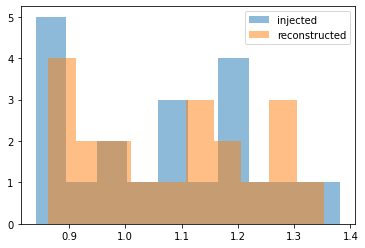

In [38]:

plt.hist(simulator.bkg_norms, alpha=0.5, label='injected')
plt.hist(bkg_computed, alpha=0.5, label = 'reconstructed')
plt.legend()

In [39]:
## strength

In [40]:
d0 = datasets[0]

In [41]:
bkg = FoVBackgroundModel(dataset_name=d0.name)
bkg.spectral_model.norm.value = simulator.bkg_norms[0]
d0.models = [bkg, model]


In [42]:
flux_model = d0.evaluators['model-simu'].compute_flux()

In [43]:
flux_model.get_spectrum(region).data.sum()

3.89128233391549e-12

In [44]:
d0.background.get_spectrum(region).data.sum()

67.34151951479937

In [45]:
d0.models[0].

SyntaxError: invalid syntax (<ipython-input-45-c8044ee815e0>, line 1)

In [ ]:
20 * 28 /60

In [ ]:
bkg.parameters.to_table()